# Code for the Hyperspectral Image Denoising via Matrix Factorization and Deep Prior Regularization Paper

In [5]:
# external
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization, Concatenate, Conv3D, Dense, Input
from keras.models import Model, load_model
from tensorflow import keras

%matplotlib inline

# set seed for reproducibility
tf.random.set_seed(42)

In [6]:
# optional line of code  (can comment out if you don't need it)
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], enable=True)

Initializations of:
- M and N = size of image
- L = spectral bands of image
- X = image
- sigma = standard deviation
- N = white gaussain noise
- S = sparse noise

In [3]:
# please note that the values of M, N, L might be changed in the future
# M, N, L = 512, 512, 640

# M*N hyperspectral image with L spectral bands
# X = tf.random.uniform(shape=([M,N,L]), minval=-1, maxval=1,
#                       dtype=tf.float32, seed=42, name='X')

# white Gaussian noise N(0, sigma**2)
# sigma =
# N =

# sparse noise
# S = np.random.default_rng().laplace(, , 1000)

In [7]:
PATH = "/content/indian_pine_array.npy"
data = np.load(PATH)
dataset = tf.convert_to_tensor(data, dtype="uint16")
dataset.shape

TensorShape([145, 145, 200])

- 145 by 145 is the image size. 
- 200 is the number of channels.

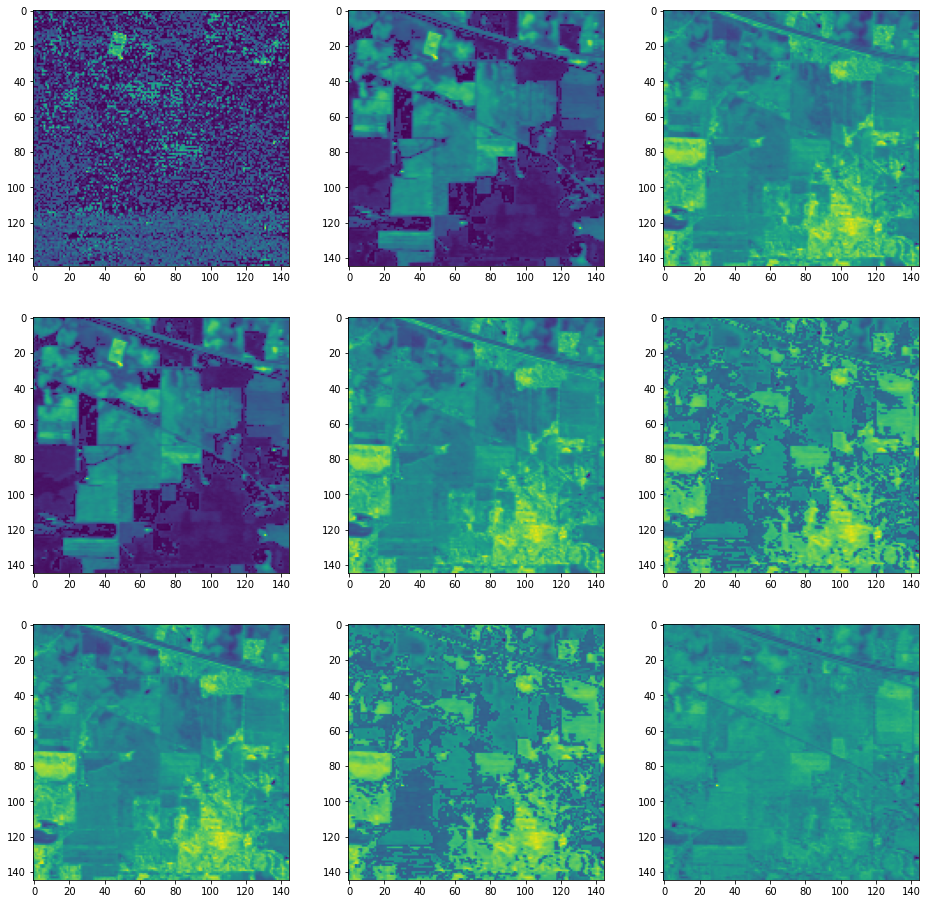

In [8]:
# Visualizing some images
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(dataset[:, :, (i + j) * 20]);

**The noise for this dataset is very low. Must add more noise. Check paper for accurate implementation.**

In [9]:
# noise for our data
np.random.normal(loc=0.0, scale=1.0, size=dataset.shape).shape

(145, 145, 200)

In [10]:
# Let's add some noise to our images
# Subject to change as per the noise requirements given in the paper
noise = np.random.normal(loc=0.0, scale=1.0, size=dataset.shape)
noise_factor = 0.1
X = dataset + noise_factor * noise  # noisy data
Y = dataset  # denoised data, ie, original data

In [11]:
# X is the data we'll feed to our model
# Y is the target which our model will learn from`
print(X.shape, Y.shape, sep="\n\n")

(145, 145, 200)

(145, 145, 200)


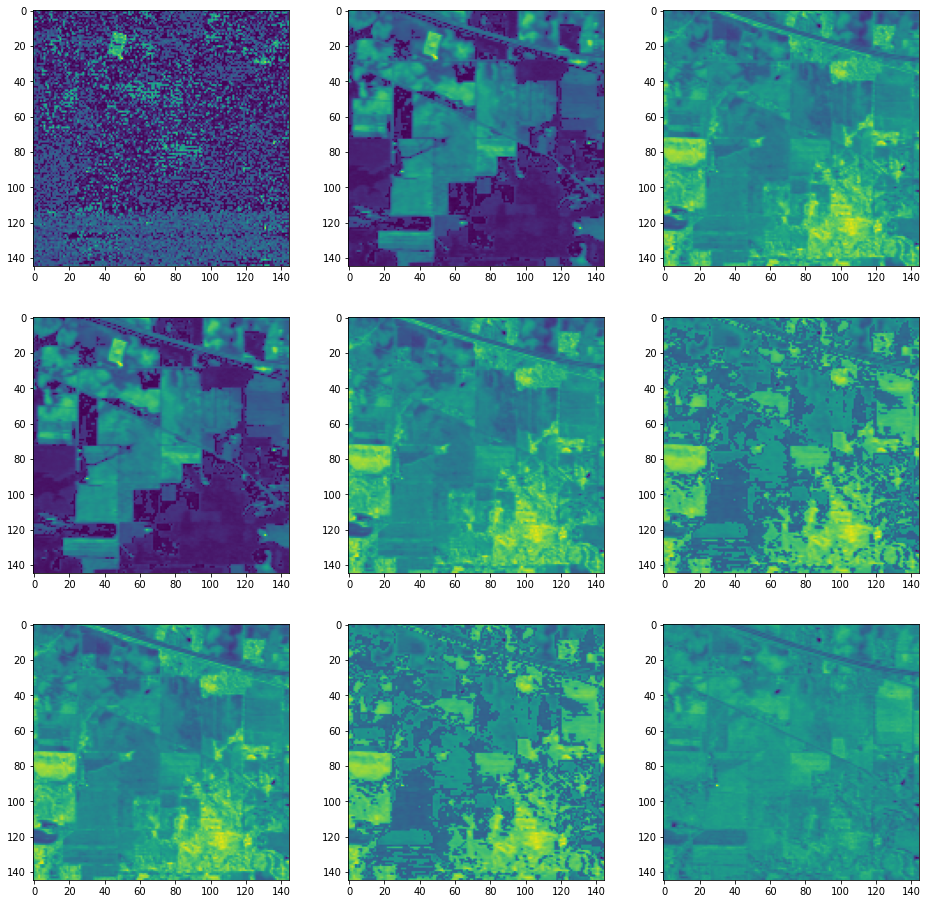

In [12]:
# Visualize noisy data
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(X[:, :, (i + j) * 20]);

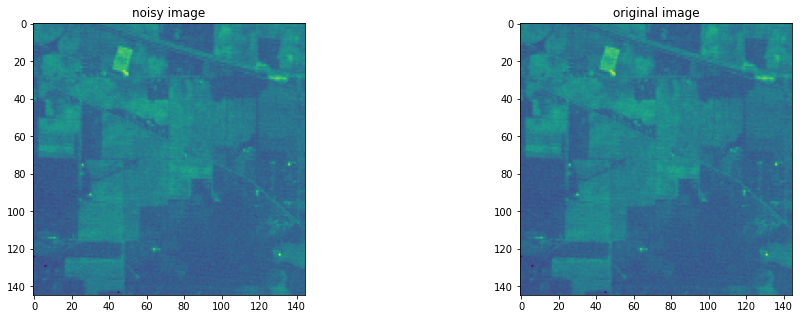

In [13]:
# Let's take one image and compare its original version with its noisy version side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# noisy image
axes[0].imshow(X[:, :, 3])
axes[0].set_title("noisy image")

# original image
axes[1].imshow(Y[:, :, 3])
axes[1].set_title("original image");

# Model Architecture

**I'm using functional API, as subclassing API is giving errors...**

In [ ]:
# a = np.random.rand(1,2,3)
# b = np.random.rand(1,2,4)
# Concatenate(axis=-1)([a,b])

<tf.Tensor: shape=(1, 2, 7), dtype=float32, numpy=
array([[[0.14969799, 0.5818814 , 0.33709663, 0.7815412 , 0.608036  ,
         0.52675104, 0.4701548 ],
        [0.43990275, 0.16061476, 0.00949638, 0.5600372 , 0.09987282,
         0.777958  , 0.27935213]]], dtype=float32)>

In [ ]:
# M, N, L = dataset.shape
# M, N, L

In [67]:
# Input as specified in the paper
# M, N, L = 180, 180, 1   # these are the values mentioned in the paper
M, N, L = 145, 145, 200
input_shape = (1, M, N, L)
input_layer = Input(shape=input_shape)

# Model starts
model_input = input_layer
# Block 1
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 1),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=1,
    name="block1",
)(model_input)
x = BatchNormalization()(x)
# Block 2
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=2,
    name="block2",
)(x)
x = BatchNormalization()(x)
# Block 3
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=4,
    name="block3",
)(x)
x = BatchNormalization()(x)
# Block 4
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=3,
    name="block4",
)(x)
x = BatchNormalization()(x)
# Block 5
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=4,
    name="block5",
)(x)
x = BatchNormalization()(x)
# Block 6
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=2,
    name="block6",
)(x)
x = BatchNormalization()(x)
# Block 7
x = Conv3D(
    filters=64,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    dilation_rate=1,
    name="block7",
)(x)
# Skip Connection
x = Concatenate(axis=-1)([x, input_layer])
x = BatchNormalization()(x)

# Block 8 -- (not in the paper) I added this so as to match the
# spectral/channels dimension with the dimensions of the original image
output = Conv3D(
    filters=200,
    kernel_size=(3, 3, 64),
    activation="relu",
    padding="same",
    strides=1,
    name="block8",
)(x)

In [68]:
mymodel = Model(model_input, output)
mymodel.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 145, 145  0           []                               
                                , 200)]                                                           
                                                                                                  
 block1 (Conv3D)                (None, 1, 145, 145,  115264      ['input_5[0][0]']                
                                 64)                                                              
                                                                                                  
 batch_normalization_28 (BatchN  (None, 1, 145, 145,  256        ['block1[0][0]']                 
 ormalization)                   64)                                                        

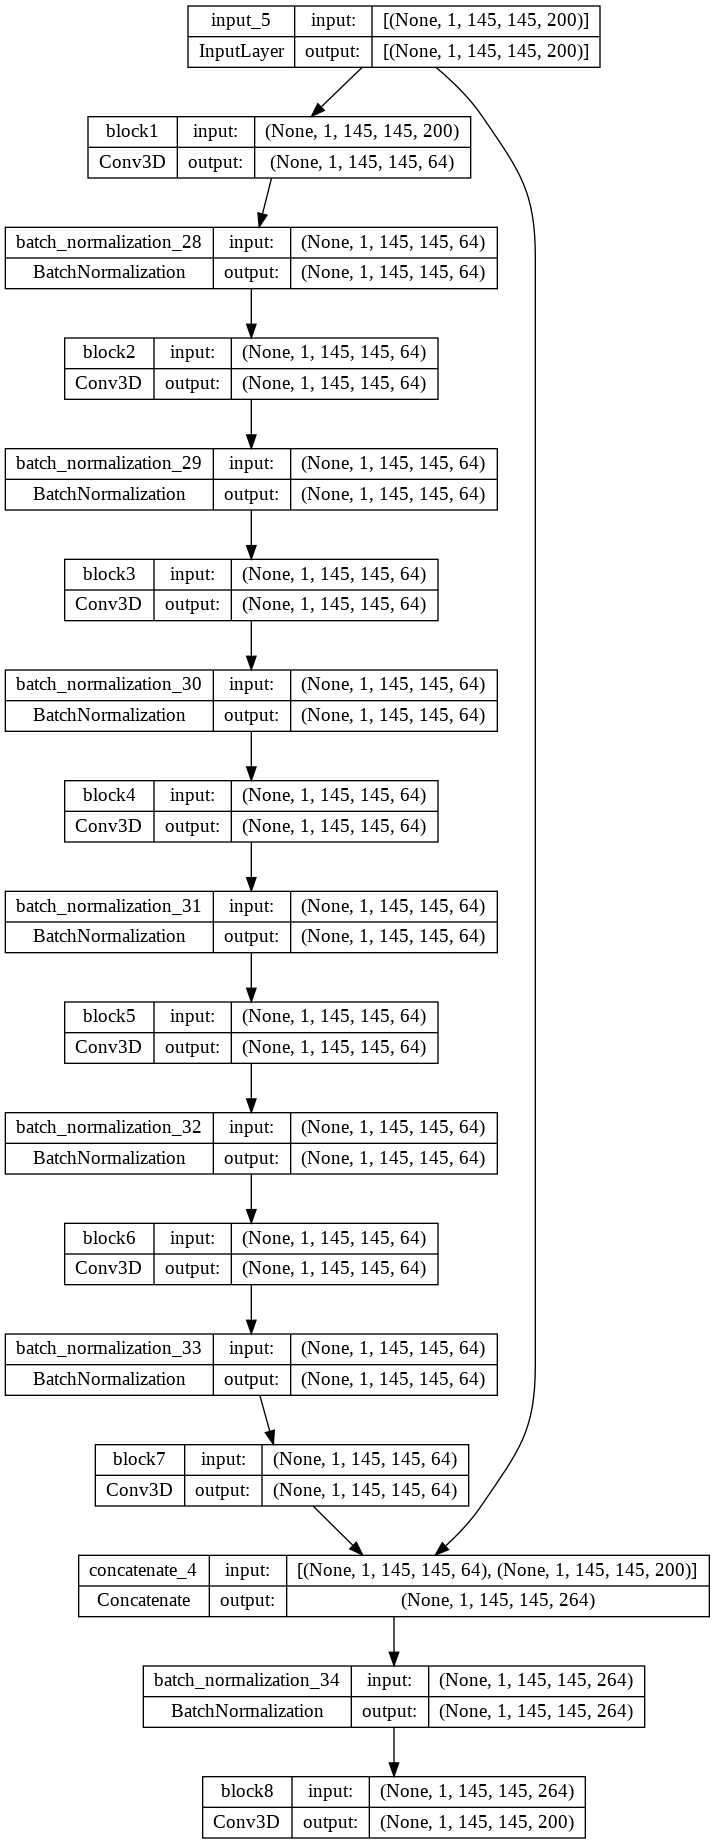

In [69]:
# Show graph of the model
keras.utils.plot_model(mymodel, "my_model_graph.png", show_shapes=True)

# Model Hyperparameters

In [70]:
# Reshaping this data to feed to our model
X = tf.reshape(X, (1, 1, 145, 145, 200))
Y = tf.reshape(X, (1, 1, 145, 145, 200))

In [71]:
# we need to build a custom loss function as specified in the paper
# since I don't have a custom loss function (very difficult to understand from paper),
# so, I'm using binary_crossentropy
custom_loss_fn = "binary_crossentropy"

In [72]:
# the paper mentions something about using quality assessment metrics: PSNR, SAM, ERGAS and SSIM
# I'm not sure what these mean
custom_metrics = None

In [77]:
lr = 1e-3  # also try 3e-4 (aka karpathy's constant)
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
weight_decay = 1e-4
# optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, weight_decay=weight_decay,
#                                                   beta_1=b1, beta_2=b2, epsilon=epsilon)
# optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, beta_1=b1, beta_2=b2, epsilon=epsilon)

epochs = 60
# minibatch_size = 256
minibatch_size = 1

mycallback = ModelCheckpoint("HSI_MF_1.h5", save_best_only=True, monitor="loss")

# we'll have to design a custom loss function as specified in the paper

# mymodel.compile(loss=custom_loss_fn, optimizer=optimizer, metrics=custom_metrics)
# I'm using 'Adam' instead of the experimental.Adam as .h5 file does not store it
mymodel.compile(loss=custom_loss_fn, optimizer="Adam")

In [79]:
history = mymodel.fit(
    X, Y, batch_size=minibatch_size, epochs=epochs, verbose=1, callbacks=mycallback
)

Epoch 1/60
1/1 [==============================] - 5s 5s/step - loss: -23273.8281
Epoch 2/60
1/1 [==============================] - 5s 5s/step - loss: -23553.8574
Epoch 3/60
1/1 [==============================] - 5s 5s/step - loss: -23798.0410
Epoch 4/60
1/1 [==============================] - 5s 5s/step - loss: -24053.2070
Epoch 5/60
1/1 [==============================] - 5s 5s/step - loss: -24293.9551
Epoch 6/60
1/1 [==============================] - 5s 5s/step - loss: -24538.2227
Epoch 7/60
1/1 [==============================] - 5s 5s/step - loss: -24748.2695
Epoch 8/60
1/1 [==============================] - 5s 5s/step - loss: -24950.4688
Epoch 9/60
1/1 [==============================] - 5s 5s/step - loss: -25157.3633
Epoch 10/60
1/1 [==============================] - 5s 5s/step - loss: -25356.4355
Epoch 11/60
1/1 [==============================] - 5s 5s/step - loss: -25587.6680
Epoch 12/60
1/1 [==============================] - 5s 5s/step - loss: -25827.2344
Epoch 13/60
1/1 [========

In [83]:
pred = mymodel(Y)
pred

<tf.Tensor: shape=(1, 1, 145, 145, 200), dtype=float32, numpy=
array([[[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.00000

In [85]:
pred2 = tf.reshape(pred, (145, 145, 200))
pred2.shape

TensorShape([145, 145, 200])

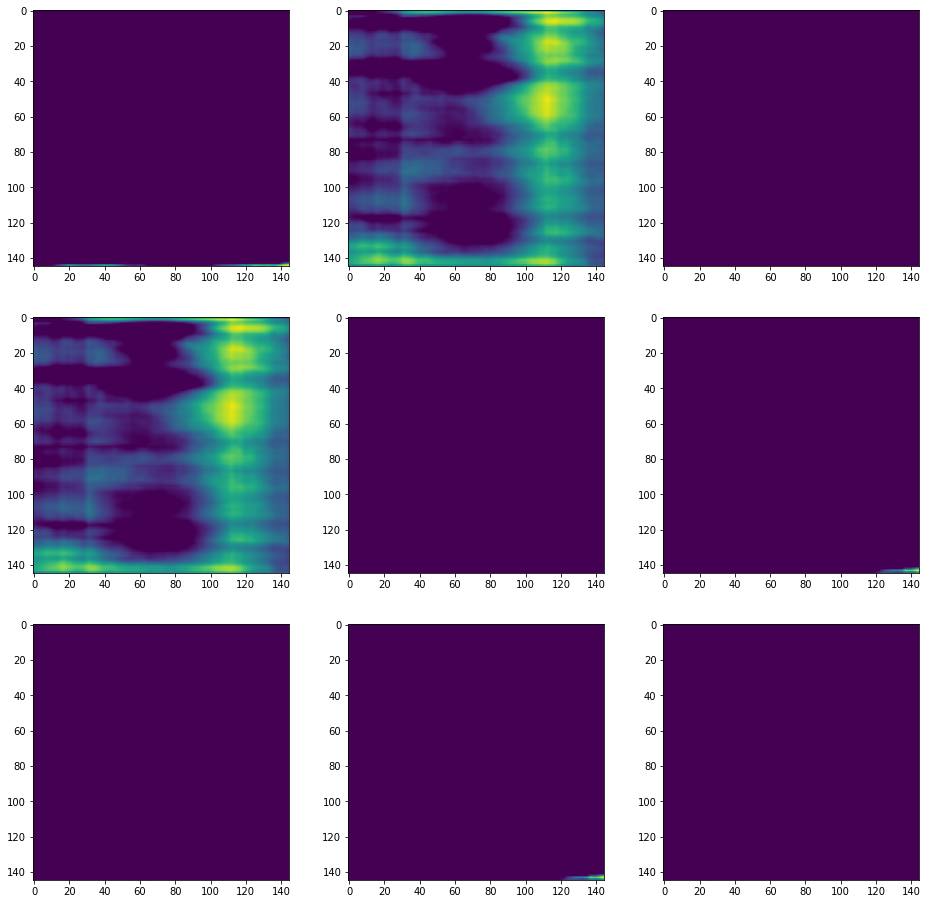

In [91]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(pred2[:, :, (i + j) * 20])